### Libs

In [274]:
import requests
import json
import numpy as np
import pandas as pd
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import folium

### General Class

In [275]:
class DistanceTable:
    def __init__(self, raw_data):
        self.raw_data = raw_data
    
    def get_coordinates(self):
        coordinates = []
        coordinates.append(self.raw_data['origin'])
        for delivery in self.raw_data['deliveries']:
            coordinates.append(delivery['point'])
        return coordinates
    
    def calc_distances(self, coordinates):
        n_coordinates = len(coordinates)
        distances = np.zeros((n_coordinates, n_coordinates))
        for i in range(n_coordinates):
            for j in range(n_coordinates):
                if i != j:
                    origin = f"{coordinates[i]['lng']},{coordinates[i]['lat']}"
                    destination = f"{coordinates[j]['lng']},{coordinates[j]['lat']}"
                    route_str = ";".join([origin, destination])
                    query = f"https://router.project-osrm.org/route/v1/driving/{route_str}?overview=false"
                    response = requests.get(query)
                    data = response.json()
                    distances[i][j] = data["routes"][0]["distance"]
        return distances
    
    def calc_distances_matrix(self):
        points = self.get_coordinates()
        distances = self.calc_distances(points)
        df = pd.DataFrame(distances)
        df.to_csv('dataset\distances_matrix.csv', index=False)
    
    def read_csv(self):
        return pd.read_csv('dataset\distances_matrix.csv')

In [276]:
class Delivery:
    def __init__(self, raw_delivery, index):
        self.id = raw_delivery["id"]
        self.size = raw_delivery["size"]

In [277]:
class DepotNet:
    def __init__(self, raw_data):
        self.vehicle_capacity = raw_data["vehicle_capacity"]
        self.deliveries = [Delivery(raw_data["deliveries"][i], i) for i in range(len(raw_data["deliveries"]))]

### Data

In [278]:
with open('dataset\cvrp_castanhal.json') as json_file:
    raw_data = json.load(json_file)
    for i in range(len(raw_data["deliveries"])):
        raw_data["deliveries"][i]["id"] = i + 1

dt = DistanceTable(raw_data)
#dt.calc_distances_matrix()
distances_matrix = dt.read_csv()

### Tabu Search

In [279]:
class TabuSearch:
    def __init__(self, distances_matrix, depot_net, max_iterations, n_neighbors, tabu_list_size):
        self.distances_matrix = distances_matrix
        self.depot_net = depot_net
        self.max_iterations = max_iterations
        self.n_neighbors = n_neighbors
        self.tabu_list_size = tabu_list_size
        self.solution = []
        self.best_solution = []
        self.best_solutions = pd.DataFrame(columns=[f"x_{i}" for i in range(len(self.depot_net.deliveries))]+["y"])
        self.best_neighborhood = pd.DataFrame(columns=[f"x_{i}" for i in range(len(self.depot_net.deliveries))]+["y"])
        self.tabu_list = []
        self.run()

    def generate_solution_initial(self):
        n = len(self.depot_net.deliveries)
        solution = np.random.choice([i for i in range(n)], n, replace=False)
        return [self.depot_net.deliveries[idx].id for idx in solution]
    
    def udpate_best_solutions(self, solution, solution_cost):
        s = pd.Series([self.depot_net.deliveries[idx-1].id for idx in solution]+[solution_cost],index=[f"x_{i}" for i in range(len(solution))]+["y"])
        self.best_solutions = self.best_solutions.append(s, ignore_index=True)
        df = self.best_solutions.iloc[:, :-1].astype(int)
        df["y"] = self.best_solutions["y"]
        self.best_solutions = df

    def udpate_best_neighborhood(self, solution, solution_cost):
        s = pd.Series([self.depot_net.deliveries[idx-1].id for idx in solution]+[solution_cost],index=[f"x_{i}" for i in range(len(solution))]+["y"])
        self.best_neighborhood = self.best_neighborhood.append(s, ignore_index=True)
        df = self.best_neighborhood.iloc[:, :-1].astype(int)
        df["y"] = self.best_neighborhood["y"]
        self.best_neighborhood = df
    
    def solution_cost(self, solution):
        route_list = [0]
        weight = 0
        for delivery in [self.depot_net.deliveries[idx-1] for idx in solution]:
            #Considerando que cada uma das entregas possui peso menor que a capacidade máxima do carro
            if (weight + delivery.size) <= self.depot_net.vehicle_capacity:
                weight += delivery.size
                route_list.append(delivery.id)
            else:
                route_list.append(0)
                weight = delivery.size
                route_list.append(delivery.id)
        route_list.append(0)
        costs = [self.distances_matrix.iloc[route_list[i],route_list[i+1]] for i in range(len(route_list)-1)] 
        return sum(costs)
    
    def swap(self, solution):
        i, j = np.random.choice(len(solution)-1, 2, replace=False)
        solution[i], solution[j] = solution[j], solution[i]
        return solution
    
    def diference_solutions(self, solution, best_neighbor):
        indexs = [i for i in range(len(solution)) if solution[i] != best_neighbor[i]]
        return indexs
    
    def generate_neighbors(self):
        neighbors = []
        neighbors_cost = []
        for _ in range(self.n_neighbors):
            neighbor = self.swap(self.solution.copy())
            while neighbor in neighbors:
                neighbor = self.swap(self.solution.copy())
            neighbor_cost = self.solution_cost(neighbor)
            if neighbors_cost == []:
                neighbors.append(neighbor)
                neighbors_cost.append(neighbor_cost)
            else:
                for k in range(len(neighbors_cost)):
                    if neighbor_cost < neighbors_cost[k]:
                        neighbors.insert(k, neighbor)
                        neighbors_cost.insert(k, neighbor_cost)
                        break
                    if k == len(neighbors_cost)-1:
                        neighbors.append(neighbor)
                        neighbors_cost.append(neighbor_cost)
        self.update_tabu_list(neighbors, neighbors_cost)
    
    def update_tabu_list(self, neighbors, neighbors_cost):
        if neighbors_cost[0] < self.solution_cost(self.best_solution):
            if len(self.tabu_list) == self.tabu_list_size:
                self.tabu_list.pop(0)
            self.tabu_list.append(self.diference_solutions(self.solution, neighbors[0]))
            self.solution = neighbors[0]
            self.best_solution = neighbors[0]
            self.udpate_best_neighborhood(neighbors[0], neighbors_cost[0])
        else:
            for l in range(self.n_neighbors):
                indexs_swap = self.diference_solutions(self.solution, neighbors[l])
                if indexs_swap in self.tabu_list:
                    continue
                else:
                    if len(self.tabu_list) == self.tabu_list_size:
                        self.tabu_list.pop(0)
                    self.tabu_list.append(indexs_swap)
                    self.solution = neighbors[l]
                    self.udpate_best_neighborhood(neighbors[l], neighbors_cost[l])
                    break
                
    def progress_bar(self, i):
        #clear_output(wait=True)
        pc = int(i/self.max_iterations*100)
        logic_char = 0 if i == 1 else int(pc/2)
        print(f"Executando iteração {i}/{self.max_iterations}:|{'█' * logic_char + '.' * (50 - logic_char)}|{pc}%",
              end='\r', flush=True)

    def run(self):
        self.solution = self.generate_solution_initial()
        self.best_solution = self.solution
        #initial = [self.solution, self.solution_cost(self.solution)]
        for i in range(self.max_iterations):
            self.progress_bar(i+1)
            self.generate_neighbors()
            self.udpate_best_solutions(self.best_solution, self.solution_cost(self.best_solution))
        #limpar a tela
        clear_output(wait=True)
        #print(f'Solução inicial:\n{initial[0]}\nCusto: {initial[1]}')
        #print(f'Após {i+1} iterações, temos:')
        #print(f'Solução Final:\n{self.best_solution}\nCusto: {self.solution_cost(self.best_solution)}')

### Run

In [280]:
depot_net = DepotNet(raw_data)
max_iterations = 200
n_neighbors = 100
tabu_list_size = 50
max_executions = 10
tabu_search_list = []

start_time = time.time()

for i in range(max_executions):
    print(f'Execução {i+1}/{max_executions}')
    tabu_search_list.append(TabuSearch(distances_matrix, depot_net, max_iterations, n_neighbors, tabu_list_size))

end_time = time.time()

hours = int((end_time - start_time)/3600)
minutes = int((end_time - start_time)/60) - hours*60
seconds = int((end_time - start_time)) - minutes*60 - hours*3600
print(f'Tempo de execução: {hours}h {minutes}m {seconds}s')

Tempo de execução: 0h 7m 33s


### Analysis

In [281]:
#verificar melhor execução
best_solution = tabu_search_list[0].best_solution
best_cost = tabu_search_list[0].solution_cost(best_solution)
best_tabu = tabu_search_list[0]
df_exe = pd.DataFrame(columns=['Solution', 'Cost'])

for tabu in tabu_search_list:
    cost = tabu.solution_cost(tabu.best_solution)
    df_exe.loc[len(df_exe)] = [tabu.best_solution, cost]
    
    if cost < best_cost:
        best_solution = tabu.best_solution
        best_cost = cost
        best_tabu = tabu

df_exe.to_csv('results/best_solutions_exe.csv', index=False)

##### Average Result

In [282]:
df_average = pd.DataFrame([df_exe['Cost'].mean(),df_exe['Cost'].std()],index=['mean','std']).T

df_average

,mean,std
0,139239.47,19509.096238


##### Best neighborhood (Best execution)

In [283]:
print(f'Melhores soluções das vizinhanças:')
display(best_tabu.best_neighborhood)
best_cost_neighborhood = best_tabu.best_neighborhood["y"].min()
index_best_neighborhood = best_tabu.best_neighborhood.loc[best_tabu.best_neighborhood["y"] == best_cost_neighborhood].index
print(f'Melhor(res) solução(ões) apresentada(s) no(s) índece(s):\n{index_best_neighborhood.astype(int).tolist()}')

Melhores soluções das vizinhanças:


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_26,x_27,x_28,x_29,x_30,x_31,x_32,x_33,x_34,y
0,4,10,17,25,27,19,35,33,31,3,...,9,5,2,6,1,21,14,8,7,291938.4
1,4,10,17,25,27,19,35,33,31,9,...,3,5,2,6,1,21,14,8,7,228390.1
2,4,10,17,25,27,19,11,33,31,9,...,3,5,2,6,1,21,14,8,7,221537.9
3,35,10,17,25,27,19,11,33,31,9,...,3,5,2,6,1,21,14,8,7,162527.5
4,35,10,17,25,27,19,11,33,31,9,...,3,5,2,6,1,21,14,8,7,156146.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,15,13,17,24,19,25,14,18,28,10,...,1,2,6,3,5,9,8,22,7,133804.8
196,15,13,17,24,19,25,14,18,28,10,...,1,2,6,3,5,21,8,22,7,134408.0
197,15,13,17,24,19,25,14,18,28,10,...,1,2,6,3,5,21,26,22,7,134375.5
198,15,13,17,24,19,25,14,18,28,10,...,1,2,6,3,5,12,26,22,7,133658.8


Melhor(res) solução(ões) apresentada(s) no(s) índece(s):
[131]


##### Best solutions (Best execution)

In [284]:
print(f'Melhores soluções globais por iteração:')
display(best_tabu.best_solutions)
index_best_solutions = best_tabu.best_solutions.loc[best_tabu.best_solutions["y"] == best_tabu.best_solutions["y"].min()].index
print(f'Melhor(res) solução(ões) apresentada(s) no(s) índece(s):\n{index_best_solutions.astype(int).tolist()}')

Melhores soluções globais por iteração:


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_26,x_27,x_28,x_29,x_30,x_31,x_32,x_33,x_34,y
0,4,10,17,25,27,19,35,33,31,3,...,9,5,2,6,1,21,14,8,7,291938.4
1,4,10,17,25,27,19,35,33,31,9,...,3,5,2,6,1,21,14,8,7,228390.1
2,4,10,17,25,27,19,11,33,31,9,...,3,5,2,6,1,21,14,8,7,221537.9
3,35,10,17,25,27,19,11,33,31,9,...,3,5,2,6,1,21,14,8,7,162527.5
4,35,10,17,25,27,19,11,33,31,9,...,3,5,2,6,1,21,14,8,7,156146.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,10,21,19,25,13,24,17,11,14,18,...,5,3,2,6,1,9,22,8,7,130343.8
196,10,21,19,25,13,24,17,11,14,18,...,5,3,2,6,1,9,22,8,7,130343.8
197,10,21,19,25,13,24,17,11,14,18,...,5,3,2,6,1,9,22,8,7,130343.8
198,10,21,19,25,13,24,17,11,14,18,...,5,3,2,6,1,9,22,8,7,130343.8


Melhor(res) solução(ões) apresentada(s) no(s) índece(s):
[131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]


##### Graphic convergence (Best execution)

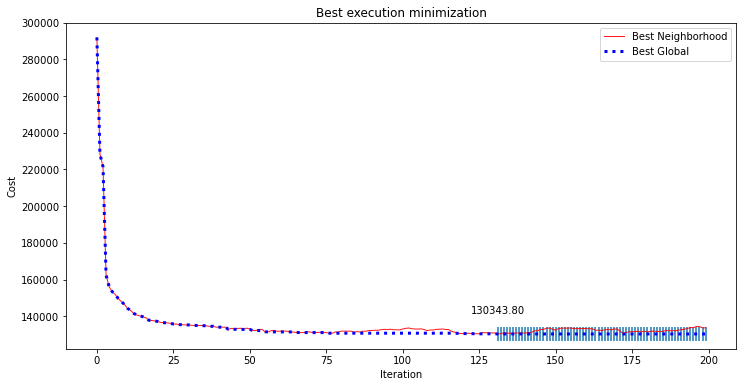

In [285]:
#Convergência na melhor execução
x = np.arange(0, max_iterations, 1)
y1 = best_tabu.best_neighborhood["y"].values
y2 = best_tabu.best_solutions["y"].values
#y2err = df_average["std"].values

fig, ax = plt.subplots()
fig.set_size_inches(12,6)
lines = ax.plot(x, y1, color='red', lw=1, alpha=0.9)
ax.plot(x, y2, color='blue', lw=3, linestyle=':')
#ax.fill_between(x, y2-y2err, y2+y2err, color='red', alpha=0.2,  linewidth=0.0)
ax.set_title('Best execution minimization')
ax.set_xlabel('Iteration')
ax.set_ylabel('Cost')
best = best_tabu.best_solutions.loc[best_tabu.best_solutions["y"] == best_tabu.best_solutions["y"].min()]["y"].values
index_min = best_tabu.best_solutions.loc[best_tabu.best_solutions["y"] == best_tabu.best_solutions["y"].min()].index
ax.scatter(index_min, best, marker='|', s=200)
ax.annotate(f'{best[0]:.2f}', (index_min[0], best[0]), xytext=(index_min[0], best[0]+10000), ha='center', va='bottom')
ax.legend(['Best Neighborhood', 'Best Global'])
plt.savefig('results/graphic_convergence_best', dpi = 300)
plt.show()

##### Response request OSRM

In [286]:
#Pegando dados da melhor solução
best_solution = [int(x) for x in best_tabu.best_solutions.iloc[-1][:-1].to_list()]
deliveries = raw_data['deliveries']

routes = []
route_list = [0]
weight = 0
for delivery in [deliveries[idx-1] for idx in best_solution]:
    #Considerando que cada uma das entregas possui peso menor que a capacidade máxima do carro
    if (weight + delivery['size']) <= raw_data['vehicle_capacity']:
        weight += delivery['size']
        route_list.append(delivery['id'])
    else:
        route_list.append(0)
        distance = sum([distances_matrix.iloc[route_list[i],route_list[i+1]] for i in range(len(route_list)-1)])
        routes.append([route_list, distance, weight])
        weight = delivery['size']
        route_list = [0, delivery['id']]
route_list.append(0) 
distance = sum([distances_matrix.iloc[route_list[i],route_list[i+1]] for i in range(len(route_list)-1)])
routes.append([route_list, distance, weight])

with open('results/best_routes_cvrp.txt', 'w', encoding="utf-8") as f:
    print(f'Quantidade de rotas calculadas: {len(routes)}')
    f.write(f'Quantidade de rotas calculadas: {len(routes)}\n')

    for i in range(len(routes)):
        route = ''
        for j, point in enumerate(routes[i][0]):
            route += f'{point}'
            if j != len(routes[i][0])-1:
                route += ' -> '
        print(f'\nRota {i+1}: ' + route)
        f.write(f'\nRota {i+1}: ' + route + '\n')
        print(f'Distância: {routes[i][1]:.2f}km')
        f.write(f'Distância: {routes[i][1]:.2f}km\n')
        print(f'Peso máximo atingido: {routes[i][2]}kg')
        f.write(f'Peso máximo atingido: {routes[i][2]}kg\n')

Quantidade de rotas calculadas: 2

Rota 1: 0 -> 10 -> 21 -> 19 -> 25 -> 13 -> 24 -> 17 -> 11 -> 14 -> 18 -> 28 -> 26 -> 12 -> 27 -> 20 -> 15 -> 23 -> 16 -> 33 -> 29 -> 31 -> 34 -> 32 -> 30 -> 35 -> 4 -> 5 -> 3 -> 2 -> 6 -> 1 -> 0
Distância: 125197.80km
Peso máximo atingido: 175kg

Rota 2: 0 -> 9 -> 22 -> 8 -> 7 -> 0
Distância: 5146.00km
Peso máximo atingido: 19kg


##### Map

In [287]:
geometrys = [[raw_data['origin']['lat'],raw_data['origin']['lng']]]
hints = [0]
for i in range(len(routes)):
    route = [deliveries[idx-1] for idx in routes[i][0]]
    for delivery in route[1:-1]:
        geometrys.append([delivery['point']['lat'], delivery['point']['lng']])
        hints.append(delivery['id'])
    geometrys.append([raw_data['origin']['lat'],raw_data['origin']['lng']])
    hints.append(0)

#pontos da rota em que são o depósito
indexs_origin = [i for i in range(len(hints)) if hints[i] == 0]

#intanciando mapa
tiles = ['OpenStreetMap','CartoDB positron','Stamen toner','Stamen Terrain']
mapa = folium.Map(location=[-1.322068, -48.039239], zoom_start=12, tiles=tiles[1])

#marcador de cada ponto da rota
for i in range(len(geometrys)):
    folium.Marker(geometrys[i], popup=f'Ponto {hints[i]}').add_to(mapa)

#marcador do depósito, ponto incial/final
folium.CircleMarker(geometrys[0], radius=10, popup='Depósito', color='red', fill=True).add_to(mapa)

color = ['red', 'blue', 'green', 'yellow', 'black', 'purple', 'orange', 'brown', 'pink', 'gray']
#criar linhas poligonais entre as rotas
for i in range(len(indexs_origin)-1):
    folium.PolyLine(geometrys[indexs_origin[i]:indexs_origin[i+1]+1], color=color[i], weight=2, opacity=0.7).add_to(mapa)

mapa

In [288]:
#salvar mapa
mapa.save('results/mapa_cvrp.html')

In [289]:
#calcular no OSRM com a melhor solução encontrada pela matriz de distância 
#para comparar os resultados
geometrys2 = [[geometrys[i][1], geometrys[i][0]] for i in range(len(geometrys))]

geometry_str = []
for geometry in geometrys2:
    geometry_str.append(f'{geometry[0]},{geometry[1]}')

route_str = ";".join(geometry_str)

query = f"https://router.project-osrm.org/route/v1/driving/{route_str}?overview=false"

response = requests.get(query)
data = response.json()
print(hints)
print(data["routes"][0]["distance"])

[0, 10, 21, 19, 25, 13, 24, 17, 11, 14, 18, 28, 26, 12, 27, 20, 15, 23, 16, 33, 29, 31, 34, 32, 30, 35, 4, 5, 3, 2, 6, 1, 0, 9, 22, 8, 7, 0]
138266.9
